In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
import os

In [ ]:
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset Paths
dataset_path = "/content/drive/MyDrive/kidney_cancer_dataset"
train_path = os.path.join(dataset_path, "DATASET/train")
val_path = os.path.join(dataset_path, "DATASET/val")

In [ ]:
# Image size & batch size
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
# Augmentation & Normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5897 images belonging to 2 classes.
Found 1473 images belonging to 2 classes.


In [ ]:
# Compute Class Weights
y_train = train_data.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.7242692213215426, 1: 1.6147316538882803}


In [ ]:
# Load Pretrained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:100]:  # Unfreeze last few layers for fine-tuning
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train Model
history = model.fit(train_data, validation_data=val_data,
                    epochs=10, class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1464s 8s/step - accuracy: 0.7566 - loss: 0.4521 - val_accuracy: 0.7733 - val_loss: 0.4463
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9836 - loss: 0.0537 - val_accuracy: 0.9647 - val_loss: 0.0851
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.9888 - loss: 0.0277 - val_accuracy: 0.8730 - val_loss: 0.3077
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 366s 2s/step - accuracy: 0.9961 - loss: 0.0160 - val_accuracy: 0.9661 - val_loss: 0.0848
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9975 - loss: 0.0095 - val_accuracy: 0.9912 - val_loss: 0.0180
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9981 - loss: 0.0073 - val_accuracy: 0.9946 - val_loss: 0.0149
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9895 - loss: 0.0323 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9975 - loss: 0.0076 - val_acc

In [ ]:
# Evaluate Model
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 1.0000 - loss: 7.5299e-05
Validation Accuracy: 1.00


In [ ]:
# Predictions & Classification Report
y_true = val_data.classes
y_pred_probs = model.predict(val_data)
y_pred = (y_pred_probs > 0.6).astype(int)  # Adjusted threshold

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Tumor']))

47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.68      0.68      0.68      1016
       Tumor       0.29      0.29      0.29       457

    accuracy                           0.56      1473
   macro avg       0.48      0.48      0.48      1473
weighted avg       0.56      0.56      0.56      1473



In [ ]:
# Save Model
model.save("/content/drive/MyDrive/kidney_cancer_mobilenetv2_balanced.h5")

NameError: name 'model' is not defined

In [ ]:
# Load Model for Testing
model = tf.keras.models.load_model("/content/drive/MyDrive/kidney_cancer_mobilenetv2_balanced.h5")

In [ ]:
# Upload & Predict Image
def predict_image():
    from google.colab import files
    import cv2
    uploaded = files.upload()

    for filename in uploaded.keys():
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.expand_dims(img, axis=0) / 255.0  # Normalize

        pred_prob = model.predict(img)[0][0]  # Get probability
        confidence = pred_prob if pred_prob > 0.5 else (1 - pred_prob)  # Adjust confidence for both classes

        prediction = "🔴 Tumor" if pred_prob > 0.6 else "🟢 Normal"

        # Show Image
        plt.imshow(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"{prediction}\nConfidence: {confidence:.2%}")  # Show confidence in %
        plt.show()

        print(f"🔍 Prediction: {prediction} (Confidence: {confidence:.2%})")


In [ ]:
# Run Prediction
predict_image()

Saving Normal- (100).jpg to Normal- (100).jpg


NameError: name 'IMG_SIZE' is not defined

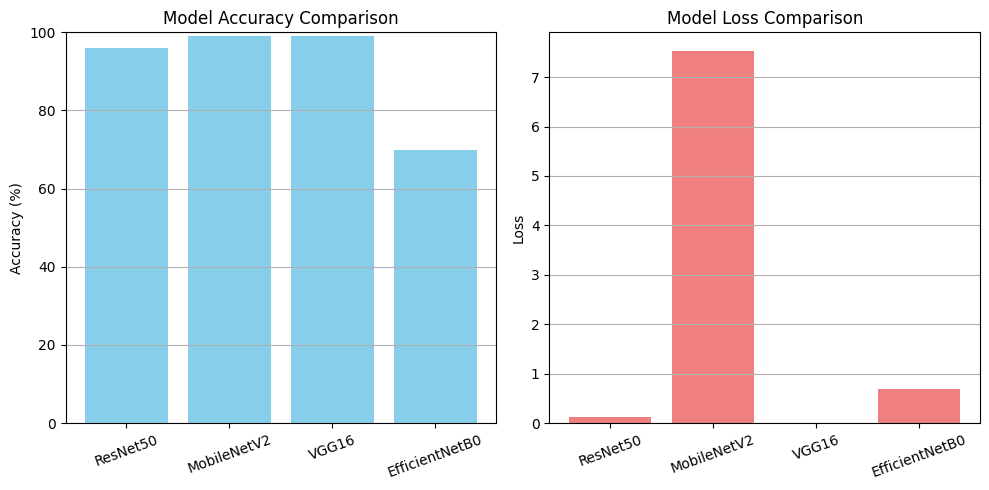

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['ResNet50', 'MobileNetV2', 'VGG16', 'EfficientNetB0']

# Accuracy and Loss values
accuracy = [96, 99, 99, 70]
loss = [0.1128, 7.5299, 0.009, 0.6877]

# Plotting Accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(models, accuracy, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=20)
plt.grid(True, axis='y')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.bar(models, loss, color='lightcoral')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xticks(rotation=20)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()
